In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
from scipy.optimize import curve_fit
from scipy.integrate import quad
import math
from scipy import stats

import sys


current_dir = '/home/marian/CIGAR_ANALYSIS/CIGAR/notebooks'

# Build the absolute path to ../functions
functions_path = os.path.abspath(os.path.join(current_dir, '../functions'))

# Add it to sys.path
sys.path.append(functions_path)

import parse_data 
import cigar as cig

from tqdm import tqdm

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
mode = 'physics'

run = '20251016_Xe_no_source_1.5bar_17deg_54.5V_Majority'

if mode == 'physics':
    folder = f'/home/marian/CIGAR_ANALYSIS/CIGAR/ProcessedWaveforms/{run}' # CHANGE TO YOUR PATH
elif mode == 'test':
    folder = f"/home/marian/CIGAR_ANALYSIS/CIGAR/outputs"

outfolder = f"/home/marian/CIGAR_ANALYSIS/CIGAR/outputs/test/"

if not os.path.exists(outfolder):
    os.makedirs(outfolder)
    print(f"Folder '{outfolder}' created.")
else:
    print(f"Folder '{outfolder}' already exists.")
    
# Initialize an empty list to store DataFrames
dataframes = []

# Loop through each folder and read all CSV files
for file in os.listdir(folder):
    if file.endswith(".csv"):
        file_path = os.path.join(folder, file)
        print(file_path)
        df = pd.read_csv(file_path)
        dataframes.append(df)
            

# Merge all DataFrames into one
merged_df = pd.concat(dataframes, ignore_index=True)
merged_df = merged_df.drop(columns=["Unnamed: 0"])


Folder '/home/marian/CIGAR_ANALYSIS/CIGAR/outputs/test/' already exists.
/home/marian/CIGAR_ANALYSIS/CIGAR/ProcessedWaveforms/20251016_Xe_no_source_1.5bar_17deg_54.5V_Majority/20251016_Xe_no_source_1.5bar_17deg_54.5V_Majority_output_3.csv
/home/marian/CIGAR_ANALYSIS/CIGAR/ProcessedWaveforms/20251016_Xe_no_source_1.5bar_17deg_54.5V_Majority/20251016_Xe_no_source_1.5bar_17deg_54.5V_Majority_output_6.csv
/home/marian/CIGAR_ANALYSIS/CIGAR/ProcessedWaveforms/20251016_Xe_no_source_1.5bar_17deg_54.5V_Majority/20251016_Xe_no_source_1.5bar_17deg_54.5V_Majority_output_9.csv
/home/marian/CIGAR_ANALYSIS/CIGAR/ProcessedWaveforms/20251016_Xe_no_source_1.5bar_17deg_54.5V_Majority/20251016_Xe_no_source_1.5bar_17deg_54.5V_Majority_output_10.csv
/home/marian/CIGAR_ANALYSIS/CIGAR/ProcessedWaveforms/20251016_Xe_no_source_1.5bar_17deg_54.5V_Majority/20251016_Xe_no_source_1.5bar_17deg_54.5V_Majority_output_12.csv
/home/marian/CIGAR_ANALYSIS/CIGAR/ProcessedWaveforms/20251016_Xe_no_source_1.5bar_17deg_54.5V_M

In [28]:
merged_df.head(-1)

,event,channel,time,time_len,integral,ampl,npeaks
0,1124,CH1,1.360000e-07,6.400000e-08,0.000002,46.832176,1.0
1,1124,CH1,1.840000e-06,4.000000e-08,0.000070,2920.105957,1.0
2,1124,CH1,1.928000e-06,2.400000e-08,0.000016,1912.815186,0.0
3,1124,CH1,2.032000e-06,2.400000e-08,0.000034,2346.150879,0.0
4,1124,CH1,2.104000e-06,2.400000e-08,0.000027,2314.356689,0.0
...,...,...,...,...,...,...,...
289345,1122,CHSum,2.288000e-06,3.200000e-08,0.000098,6331.865080,0.0
289346,1122,CHSum,2.352000e-06,3.200000e-08,0.000061,3711.893501,0.0
289347,1122,CHSum,2.416000e-06,2.400000e-08,0.000025,1793.733512,0.0
289348,1122,CHSum,2.472000e-06,2.400000e-08,0.000019,1508.808876,0.0


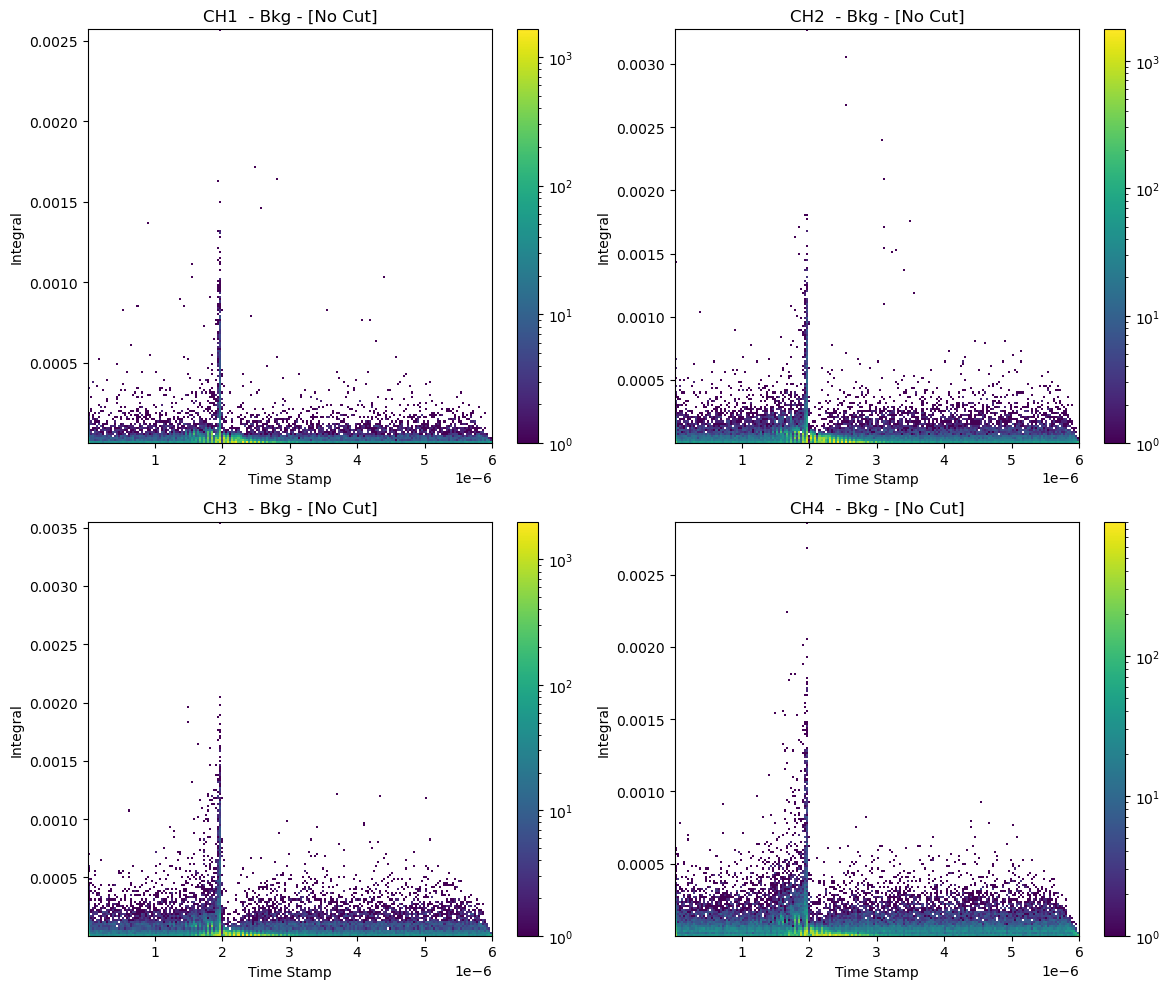

In [29]:
# Unique channels in the data
channels = ['CH1','CH2','CH3','CH4']

# Create a figure with 4 subplots (2x2 layout)
fig, axs = plt.subplots(2, 2, figsize=(12, 10))


# Plot 2D histogram for 'integral' vs 'time' for each channel
for i, ch in enumerate(channels):
    ax = axs[i // 2, i % 2]  # Determine the subplot index
    channel_data = merged_df[merged_df['channel']==ch]  # Filter data for the channel
    
    # Create 2D histogram
    h = ax.hist2d(channel_data['time'], channel_data['integral'], bins=[200,200], cmap='viridis', norm=colors.LogNorm())
    
    # Add colorbar
    plt.colorbar(h[3], ax=ax)
    
    ax.set_title(f'{channels[i]}  - Bkg - [No Cut]')
    ax.set_xlabel('Time Stamp')
    #ax.set_ylim([0,0.4e-6])
    ax.set_ylabel('Integral')
    #ax.set_ylim([0,10])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig(outfolder+'IntVsTime.png')
plt.show()

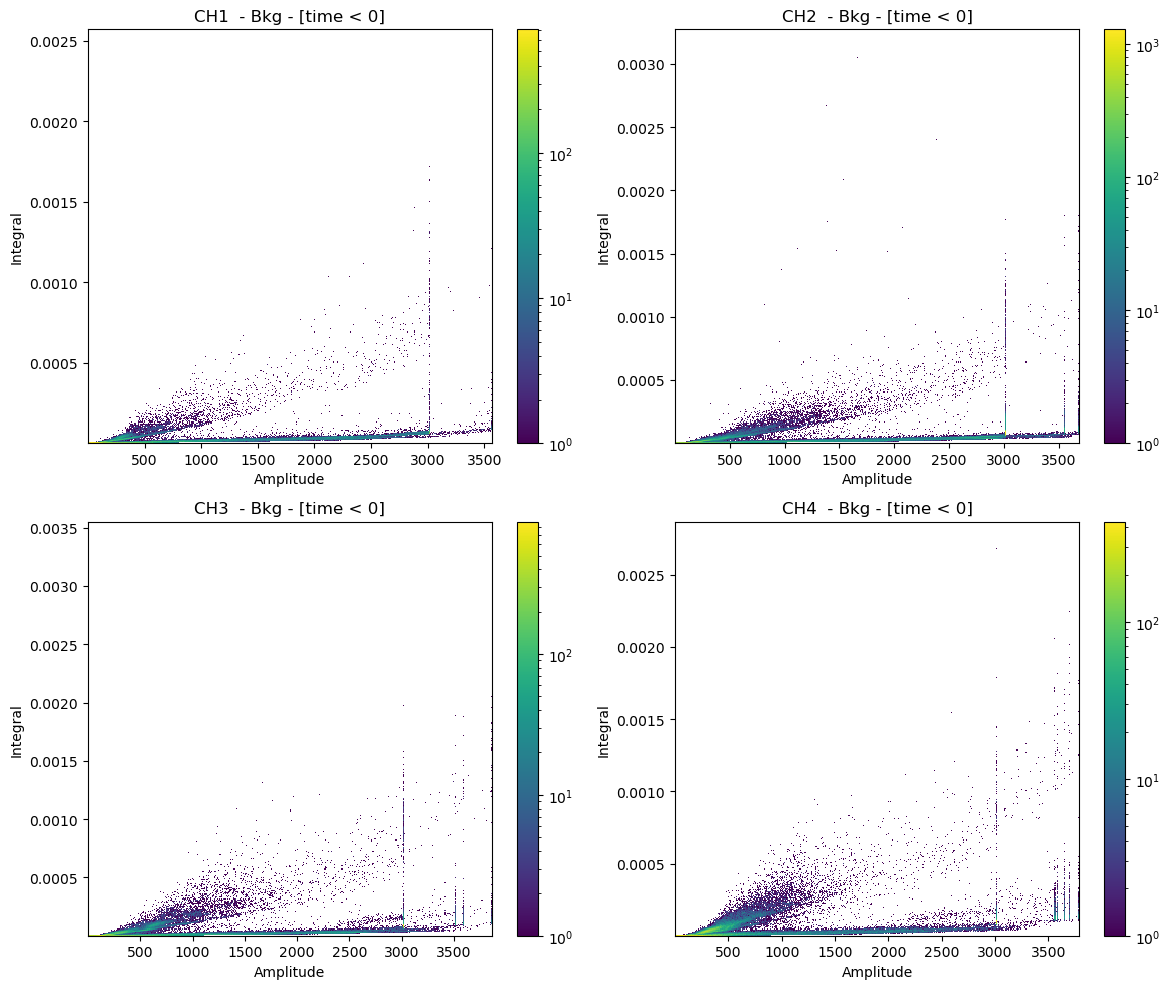

In [30]:
# Unique channels in the data
channels = ['CH1','CH2','CH3','CH4']

# Create a figure with 4 subplots (2x2 layout)
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Define the number of bins for the histogram
num_bins = 400

# Plot 2D histogram for 'integral' vs 'time' for each channel
for i, ch in enumerate(channels):
    ax = axs[i // 2, i % 2]  # Determine the subplot index
    channel_data = merged_df[merged_df['channel']==ch]  # Filter data for the channel
    
    # Create 2D histogram
    h = ax.hist2d(channel_data['ampl'], channel_data['integral'], bins=num_bins,
                  range=[(channel_data['ampl'].min(),channel_data['ampl'].max()), (channel_data['integral'].min(),channel_data['integral'].max())], 
                  cmap='viridis', norm=colors.LogNorm())
    
    # Add colorbar
    plt.colorbar(h[3], ax=ax)
    
    ax.set_title(f'{channels[i]}  - Bkg - [time < 0]')
    ax.set_xlabel('Amplitude')
    ax.set_ylabel('Integral')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig(outfolder+'IntVsAmp.png')
plt.show()


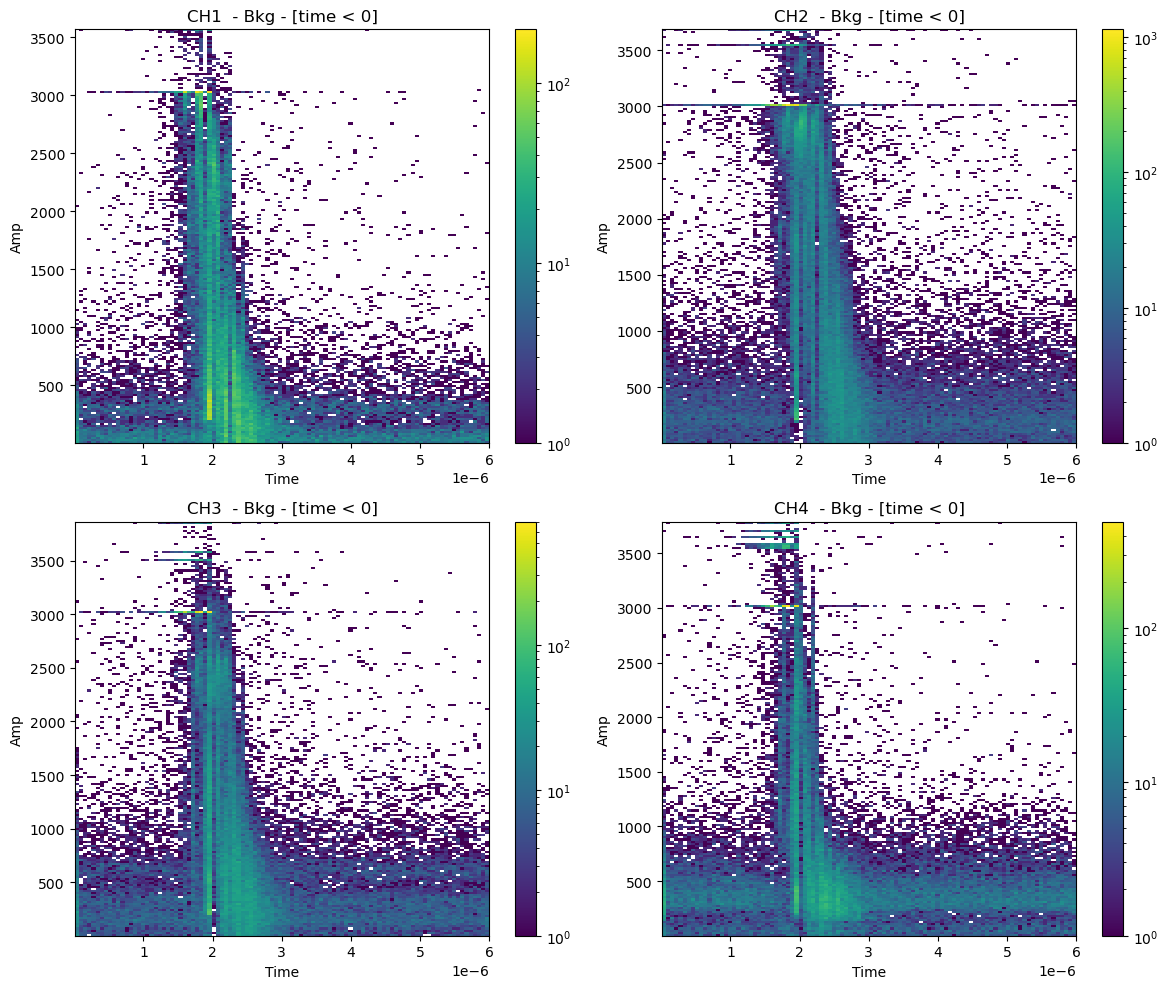

In [31]:
# Unique channels in the data
channels = ['CH1','CH2','CH3','CH4']

# Create a figure with 4 subplots (2x2 layout)
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Define the number of bins for the histogram

# Plot 2D histogram for 'integral' vs 'time' for each channel
for i, ch in enumerate(channels):
    ax = axs[i // 2, i % 2]  # Determine the subplot index
    channel_data = merged_df[merged_df['channel']==ch]  # Filter data for the channel
    
    # Create 2D histogram
    h = ax.hist2d(channel_data['time'], channel_data['ampl'], bins=[100,200], cmap='viridis', norm=colors.LogNorm())
    
    # Add colorbar
    plt.colorbar(h[3], ax=ax)
    
    ax.set_title(f'{channels[i]}  - Bkg - [time < 0]')
    ax.set_xlabel('Time')
    ax.set_ylabel('Amp')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig(outfolder+'AmpVsTime.png')
plt.show()


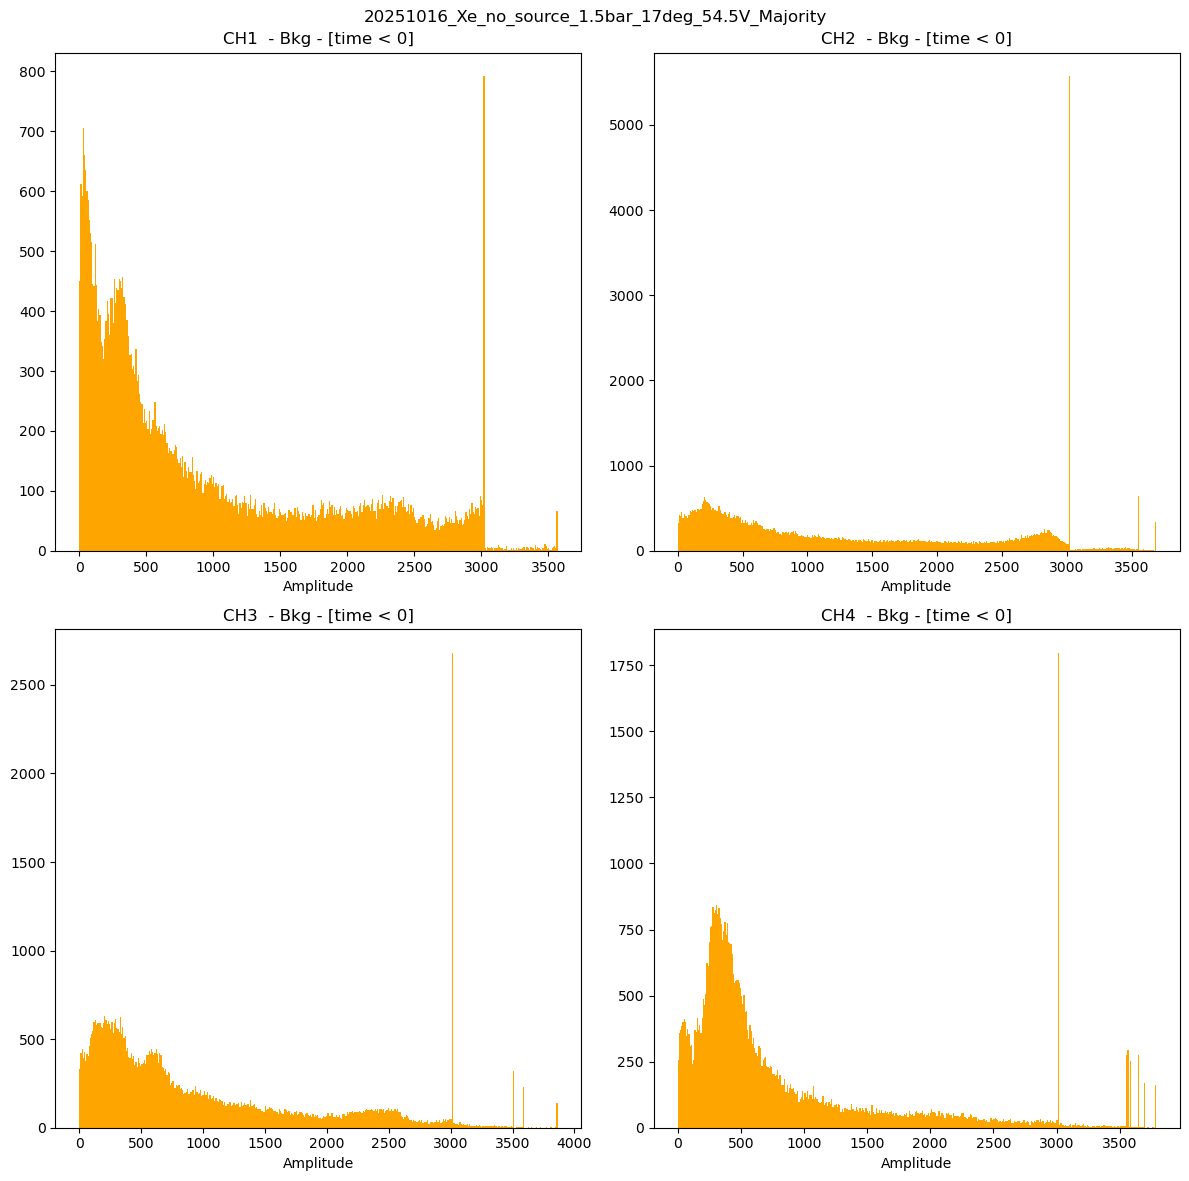

In [32]:
# Unique channels in the data
channels = ['CH1','CH2','CH3','CH4']

# Create a figure with 4 subplots (2x2 layout)
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Define the number of bins for the histogram
num_bins = 400

# Plot 2D histogram for 'integral' vs 'time' for each channel
for i, ch in enumerate(channels):
    ax = axs[i // 2, i % 2]  # Determine the subplot index
    channel_data = merged_df[(merged_df['channel']==ch) & (merged_df['integral']>0.07e-7) ]  # Filter data for the channel
    
    # Create 2D histogram
    h = ax.hist(channel_data['ampl'], bins=num_bins,range=[0,channel_data['ampl'].max()], color='orange')
        
    ax.set_title(f'{channels[i]}  - Bkg - [time < 0]')
    ax.set_xlabel('Amplitude')
    
# Adjust layout to prevent overlap
fig.suptitle(f'{run}')
plt.tight_layout()
plt.savefig(outfolder+'Amp.png')
plt.show()

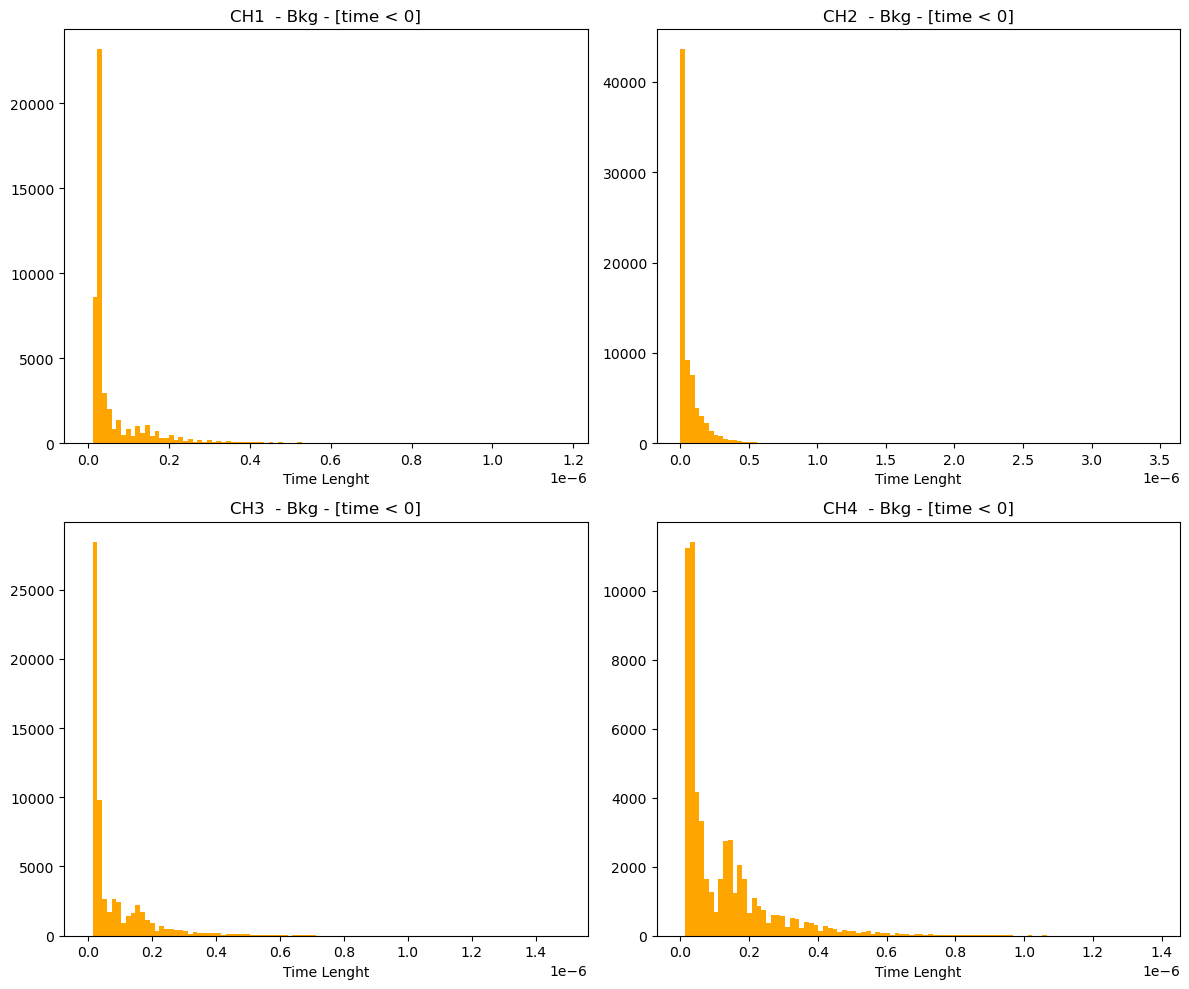

In [33]:
# Unique channels in the data
channels = ['CH1','CH2','CH3','CH4']

# Create a figure with 4 subplots (2x2 layout)
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Define the number of bins for the histogram
num_bins = 100

# Plot 2D histogram for 'integral' vs 'time' for each channel
for i, ch in enumerate(channels):
    ax = axs[i // 2, i % 2]  # Determine the subplot index
    channel_data = merged_df[(merged_df['channel']==ch) ]  # Filter data for the channel
    
    # Create 2D histogram
    h = ax.hist(channel_data['time_len'], bins=num_bins,range=[0,channel_data['time_len'].max()], color='orange')
        
    ax.set_title(f'{channels[i]}  - Bkg - [time < 0]')
    ax.set_xlabel('Time Lenght')
 
# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [34]:
def five_gaussian(x, A1, mu1, sigma1, A2, mu2, sigma2, A3, mu3, sigma3, A4, mu4, sigma4, A5, mu5, sigma5):
    return (A1 * np.exp(-(x - mu1) ** 2 / (2 * sigma1 ** 2)) +
            A2 * np.exp(-(x - mu2) ** 2 / (2 * sigma2 ** 2)) +
            A3 * np.exp(-(x - mu3) ** 2 / (2 * sigma3 ** 2)) +
            A4 * np.exp(-(x - mu4) ** 2 / (2 * sigma4 ** 2)) +
            A5 * np.exp(-(x - mu5) ** 2 / (2 * sigma5 ** 2)))


In [35]:
def check_boundaries(params, lower_bounds, upper_bounds):
    at_lower = [abs(p - l)<1e-10 for p, l in zip(params, lower_bounds)]
    at_upper = [abs(p - u)<1e-10 for p, u in zip(params, upper_bounds)]
    print(at_lower)
    print(at_upper)

In [36]:
merged_df

,event,channel,time,time_len,integral,ampl,npeaks
0,1124,CH1,1.360000e-07,6.400000e-08,0.000002,46.832176,1.0
1,1124,CH1,1.840000e-06,4.000000e-08,0.000070,2920.105957,1.0
2,1124,CH1,1.928000e-06,2.400000e-08,0.000016,1912.815186,0.0
3,1124,CH1,2.032000e-06,2.400000e-08,0.000034,2346.150879,0.0
4,1124,CH1,2.104000e-06,2.400000e-08,0.000027,2314.356689,0.0
...,...,...,...,...,...,...,...
289346,1122,CHSum,2.352000e-06,3.200000e-08,0.000061,3711.893501,0.0
289347,1122,CHSum,2.416000e-06,2.400000e-08,0.000025,1793.733512,0.0
289348,1122,CHSum,2.472000e-06,2.400000e-08,0.000019,1508.808876,0.0
289349,1122,CHSum,2.536000e-06,2.400000e-08,0.000031,2086.674892,0.0


In [37]:
merged_df.loc[merged_df.channel == 'CHSum'].integral.max()

0.0119545299270063

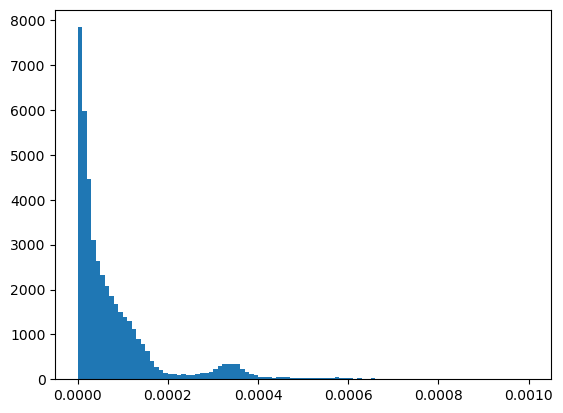

In [38]:
_ = plt.hist(merged_df.loc[merged_df.channel == 'CHSum'].integral, 100, range = (0, .001))
plt.show()

/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


3.08e+03,5.12e-08,1.41e-08,   9.61e+02,1.21e-07,1.91e-08,   5.28e+02,1.70e-07,1.69e-08,   1.09e+02,2.30e-07,1.37e-08,   3.70e+02,2.80e-07,1.78e-08,   

3.08e+03,5.12e-08,1.41e-08,   9.61e+02,1.21e-07,1.91e-08,   5.28e+02,1.70e-07,1.69e-08,   1.09e+02,2.65e-07,1.37e-08,   3.12e+01,2.80e-07,3.47e-08,   



/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


3.44e+03,5.07e-08,1.37e-08,   1.11e+03,1.16e-07,2.38e-08,   4.86e+02,1.85e-07,1.78e-08,   2.05e+02,2.42e-07,3.03e-08,   4.16e+02,2.80e-07,1.78e-08,   

3.44e+03,5.07e-08,1.37e-08,   1.11e+03,1.16e-07,2.38e-08,   4.86e+02,1.85e-07,1.78e-08,   2.05e+02,2.42e-07,3.03e-08,   4.16e+02,2.80e-07,1.78e-08,   



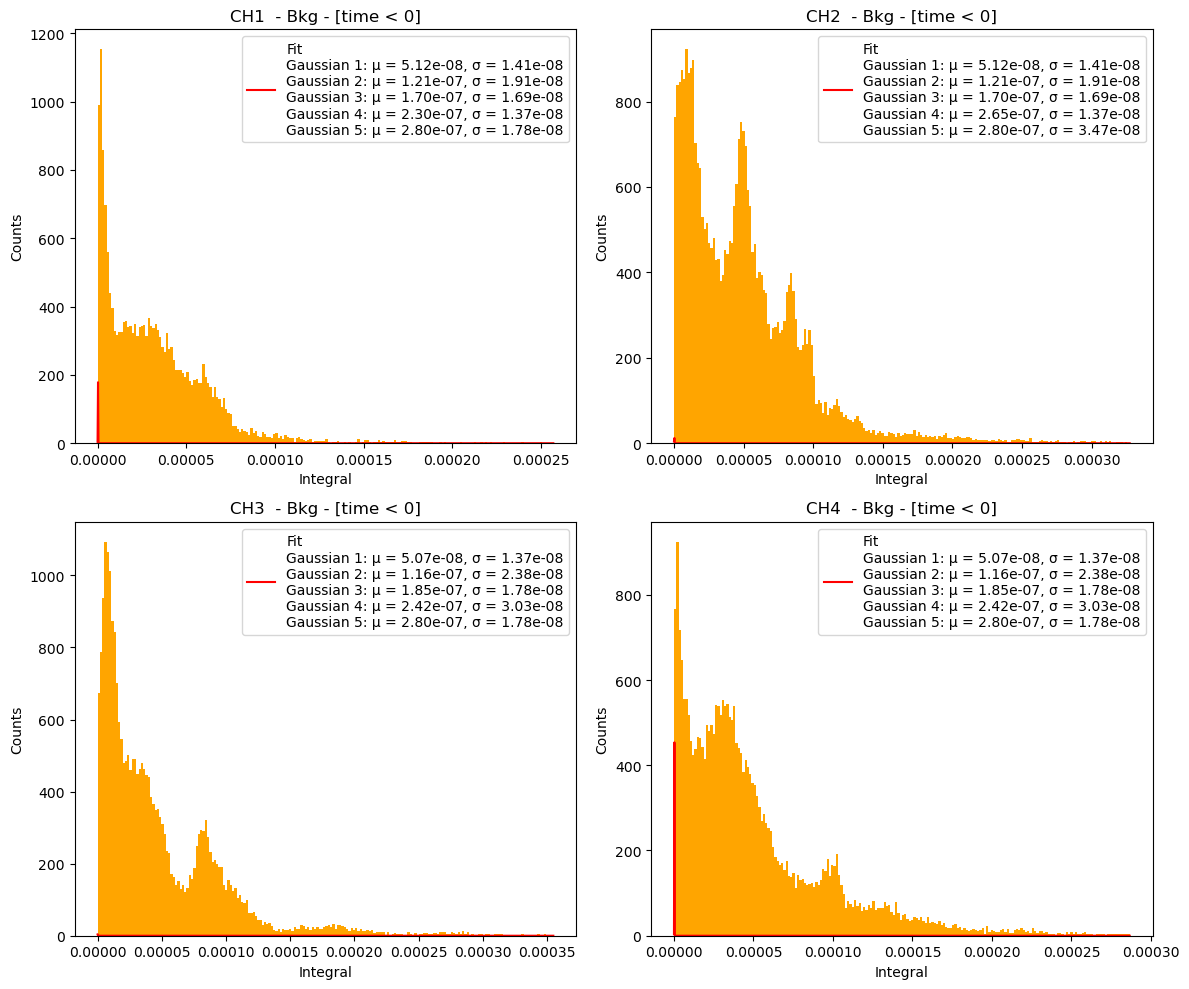

In [39]:
# Unique channels in the data
channels = ['CH1','CH2','CH3','CH4']

# Create a figure with 4 subplots (2x2 layout)
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Define the number of bins for the histogram
num_bins = [200,200,200,200]

# ranges= [[0.27e-7, 3.5e-7],[0.27e-7,3.5e-7],[0.27e-7,3.5e-7],[0.27e-7,3.5e-7]]
ranges= []

for ch in channels:
    lims = [merged_df.loc[merged_df.channel == f'{ch}'].integral.min(), 0.1*merged_df.loc[merged_df.channel == f'{ch}'].integral.max()]
    ranges.append(lims)

"""gaussian 0 pars -> 2.52e+02,2.84e-08,6.85e-09
gaussian 1 pars -> 7.60e+01,6.08e-08,1.13e-08
gaussian 2 pars -> 3.18e+01,9.55e-08,1.00e-08
gaussian 3 pars -> 1.44e+01,1.29e-07,1.29e-08
gaussian 4 pars -> 7.83e+00,1.62e-07,1.31e-08"""

initial_guess= [[3.08e+03,5.12e-08,1.41e-08,   9.61e+02,1.21e-07,1.91e-08,   5.28e+02,1.7e-07,1.69e-08,   1.09e+02,2.3e-07,1.37e-08,   3.70e+02,2.8e-07,1.78e-08], 
                [3.08e+03,5.12e-08,1.41e-08,   9.61e+02,1.21e-07,1.91e-08,   5.28e+02,1.7e-07,1.69e-08,   1.09e+02,2.65e-07,1.37e-08,   3.12e+01,2.8e-07,3.47e-08],
               [3.44e+03,5.07e-08,1.37e-08,   1.11e+03,1.16e-07,2.38e-08,   4.86e+02,1.85e-07,1.78e-08,   2.05e+02,2.42e-07,3.03e-08,   4.16e+02,2.8e-07,1.78e-08],
               [3.44e+03,5.07e-08,1.37e-08,   1.11e+03,1.16e-07,2.38e-08,   4.86e+02,1.85e-07,1.78e-08,   2.05e+02,2.42e-07,3.03e-08,   4.16e+02,2.8e-07,1.78e-08]]


indices_to_bound = [1, 2, 4, 5, 7, 8, 10, 11, 13, 14]

lower_bounds = [
    [x * 0.5 if i in indices_to_bound else 0 for i, x in enumerate(initial_guess[0])],  # Channel 0
    [x * 0.5 if i in indices_to_bound else 0 for i, x in enumerate(initial_guess[1])],  # Channel 1
    [x * 0.5 if i in indices_to_bound else 0 for i, x in enumerate(initial_guess[2])],  # Channel 2
    [x * 0.5 if i in indices_to_bound else 0 for i, x in enumerate(initial_guess[3])]   # Channel 3
]

upper_bounds = [
    [x * 1.6 if i in indices_to_bound else np.inf for i, x in enumerate(initial_guess[0])],  # Channel 0
    [x * 1.6 if i in indices_to_bound else np.inf for i, x in enumerate(initial_guess[1])],  # Channel 1
    [x * 1.6 if i in indices_to_bound else np.inf for i, x in enumerate(initial_guess[2])],  # Channel 2
    [x * 1.6 if i in indices_to_bound else np.inf for i, x in enumerate(initial_guess[3])]   # Channel 3
]

means_peak = []
means_peak_err = []

# Plot 2D histogram for 'integral' vs 'time' for each channel
for i, ch in enumerate(channels):
    ax = axs[i // 2, i % 2]  # Determine the subplot index
    channel_data = merged_df[ (merged_df['channel']==ch) & (merged_df['npeaks']==1)]  # Filter data for the channel

    #
    
    # Create 2D histogram
    counts_bg, bins_bg, _ = ax.hist(channel_data['integral'], bins=num_bins[i],range=ranges[i],color='orange')

    # Bin centers for fitting
    bin_centers = (bins_bg[:-1] + bins_bg[1:]) / 2

    
    # Fit the model to the data
    popt, pcov = curve_fit(five_gaussian, bin_centers, counts_bg, p0=initial_guess[i],bounds = (lower_bounds[i],upper_bounds[i]),maxfev=100000)

    
    for j in range(10):
        # Fit the model to the data
        popt, pcov = curve_fit(five_gaussian, bin_centers, counts_bg, p0=popt, maxfev=100000)
     
    #check_boundaries(popt,lower_bounds[i],upper_bounds[i])
    
    amps = popt[0::3]
    means = popt[1::3]   # Means (mu1, mu2, mu3, mu4, mu5)
    sigmas = popt[2::3]  # Standard deviations (sigma1, sigma2, sigma3, sigma4, sigma5)

    # Extract errors from the covariance matrix
    errors_on_params = np.sqrt(np.diag(pcov))  # Errors on all parameters

    # Extract errors on means (they correspond to every third element starting from index 1)
    errors_on_means = errors_on_params[1::3]
    
    means_peak.append(means[:-1])
    means_peak_err.append(errors_on_means[:-1])
    
    fit_label_lines = ['Fit']

    integrals=[]
    for j in [0,1,2,3,4] :
        fit_label_lines.append(f'Gaussian {j+1}: μ = {means[j]:.2e}, σ = {sigmas[j]:.2e}')
        print(f"{amps[j]:.2e},{means[j]:.2e},{sigmas[j]:.2e},",end='   ')
    print("\n")
        
    # Join the list into a single string with newline characters
    fit_label = '\n'.join(fit_label_lines)
    
    # Plot the fitted curve
    x_fit = np.linspace(0, ranges[i][1], 1000)
    y_fit = five_gaussian(x_fit, *popt)
    
    ax.plot(x_fit, y_fit, 'r-', label=fit_label)

    ax.set_title(f'{channels[i]}  - Bkg - [time < 0]')
    ax.set_xlabel('Integral')
    ax.set_ylabel('Counts')
    ax.legend()

# Adjust layout to prevent overlap
#plt.savefig(f'{outfolder}spectra{ValueBias}.png')
plt.tight_layout()
plt.savefig(outfolder+'Spectra.png')
plt.show()


In [40]:
Single_phecharge_amp = np.array([5.58e-8,5.66e-8,5.17e-8,5.34e-8])
Current_values = np.array([3.36e-6, 3.64e-6, 2.68e-6, 2.88e-6])
DCR_Values = np.array([1.75e6, 1.95e6, 1.75e6, 1.9e6])

print("Amp[CH1 CH2 CH3 CH4] = ", Single_phecharge_amp/(Current_values/DCR_Values)/50)


Amp[CH1 CH2 CH3 CH4] =  [581.25       606.42857143 675.18656716 704.58333333]


In [41]:
# Define linear function for fitting
def linear_func(x, a, b):
    return a * x + b

AttributeError: 'str' object has no attribute 'view'

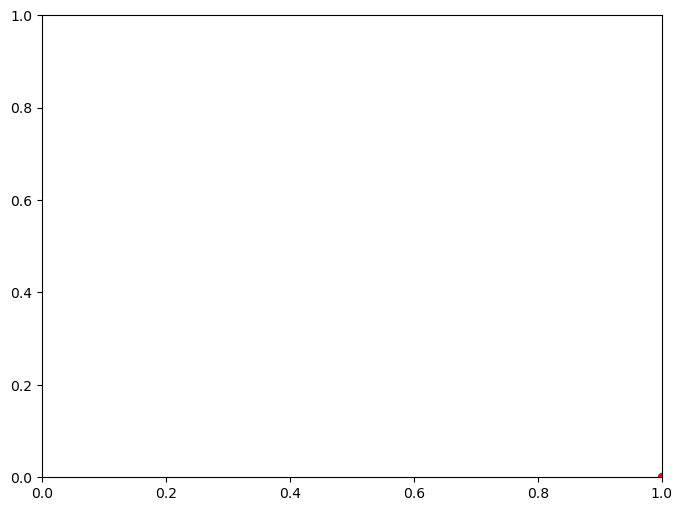

In [42]:
nPhe = [1,2,3]
means_peak = means_peak
means_peak_err = means_peak_err

# col, markers, and labels
col = ['r', 'g', 'b', 'purple']
markers = ['o', 's', 'D', '^']

# Create figure
plt.figure(figsize=(8, 6))

# Loop to plot each dataset and its linear fit
for i in range(4):
    # Fit the data
    popt, _ = curve_fit(linear_func, nPhe, means_peak[i][:len(nPhe)])  
    slope, intercept = popt

    # Generate fit line
    fit_x = np.linspace(min(nPhe), max(nPhe), 100)
    fit_y = linear_func(fit_x, *popt)

    # Create label with fit results
    label = f'CH{i+1} (y={slope:.2e}x {intercept:.2e})'
    
    # Scatter plot with error bars
    plt.errorbar(nPhe, means_peak[i][:len(nPhe)], yerr=means_peak_err[i][:len(nPhe)], fmt=markers[i], 
                 color=col[i], label=label, capsize=3, linestyle='None')
    
    # Plot the fitted line
    plt.plot(fit_x, fit_y, color=col[i], linestyle='--')

# Labels and legend
plt.xlabel('NPhe')
plt.ylabel('means_peak[i]')
plt.title('Superimposed Scatter Plots with Linear Fits')
plt.legend()
plt.grid(True)

# Show plot
plt.show()